# Exploring the UTx000 Extension Beacon Data
(Known as BPEACE2 in the [GH repo](https://github.com/intelligent-environments-lab/utx000))

# Summary
This notebook helps look at the measurements taken during the study period for the various sensors on the beacons.

In [20]:
import warnings
warnings.filterwarnings('ignore')

# Package Import

In [21]:
import sys
sys.path.append('../')

from src.features import build_features
from src.visualization import visualize
from src.reports import make_report

import pandas as pd
import numpy as np

from datetime import datetime, timedelta

# Data Import

In [22]:
beacon_data = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col=0,parse_dates=True)
# show it off:
beacon_data.head()

,TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,...,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10,z,Beacon,Beiwe,Fitbit,REDCap
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-06-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4
2020-06-11 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,30,idbkjh8u,22,4


We also need some important information regarding shipment dates to calculate completeness. So we import the beacon-specific ```id_crossover``` file.

In [23]:
details = pd.read_excel('../data/raw/bpeace2/admin/id_crossover.xlsx',sheet_name='beacon',index_col=1,
                       parse_dates=['start_date','end_date','move_date'],infer_datetime_format=True)
details.head()

,REDCap,Beacon,start_date,end_date,move_date,return_date,Lat,Long,original_start,original_end,original_move
Beiwe,,,,,,,,,,,
kyj367pi,10,1,2020-06-08,2020-09-03,2020-07-31,2020-09-02,30.312614,-97.732338,2020-06-06,2020-09-03,2020-07-31
745vq78e,55,5,2020-06-08,2020-08-23,NaT,2020-09-08,30.288012,-97.751201,2020-06-08,2020-09-09,2020-09-09
itmylz3g,61,6,2020-06-15,NaT,NaT,NaT,29.855371,-95.741200,2020-06-15,NaT,2020-09-14
zdpffrox,0,7,2020-06-01,2020-09-01,NaT,2020-09-01,30.326815,-97.744665,2020-06-02,2020-09-14,2020-09-14
xlw5ntd5,43,10,2020-06-08,2020-09-11,2020-08-10,2020-09-22,30.351693,-97.614524,2020-06-06,NaT,2020-08-10


# Base Analysis
Here we look at the raw, unaltered data in order to understand:
- what data are available? (see 4.1.1 notebook to see when participants actually measured data)
- how much data were collected?
- what are typical measurements and what does this say?
- are there any misbehaving sensors?

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import LogNorm

## What data are available?
Here we look at some basic visualizations to get a sense of the data collected

### Heatmap
These heatmaps show the values, but are more useful for determining when data are available.

Working for PM_C_2p5
	Data collected
	Plotting


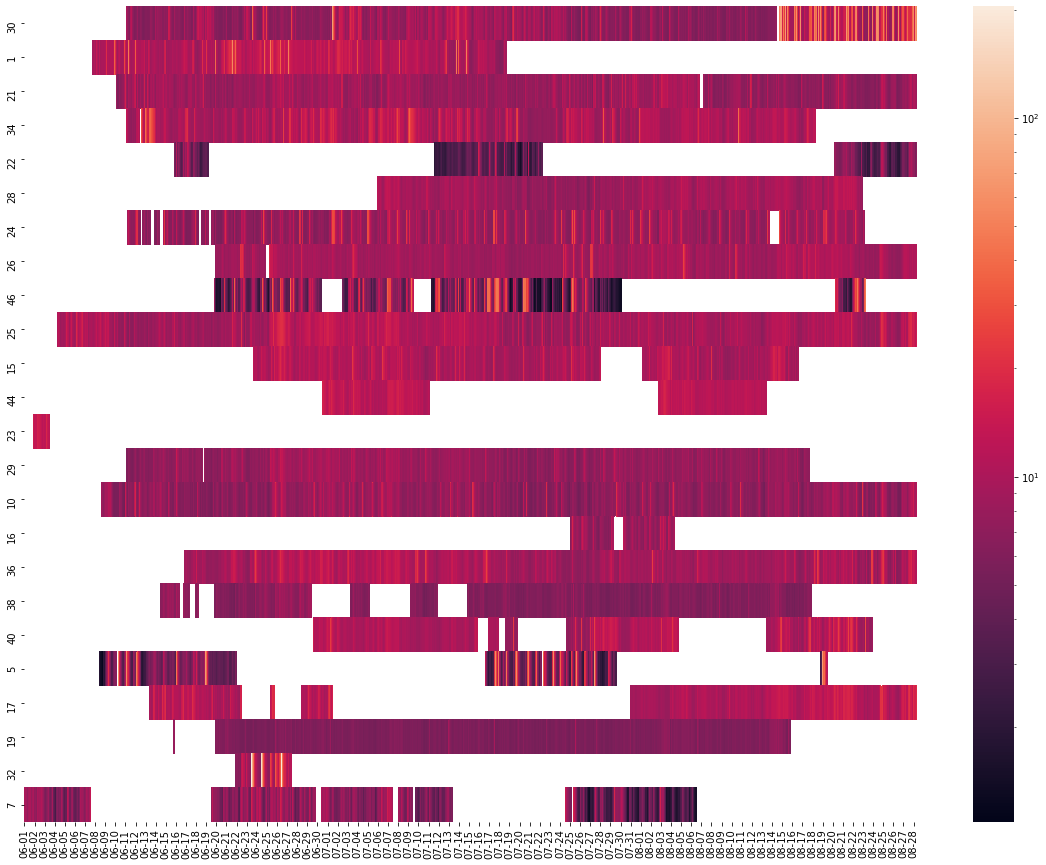

Working for CO2
	Data collected
	Plotting


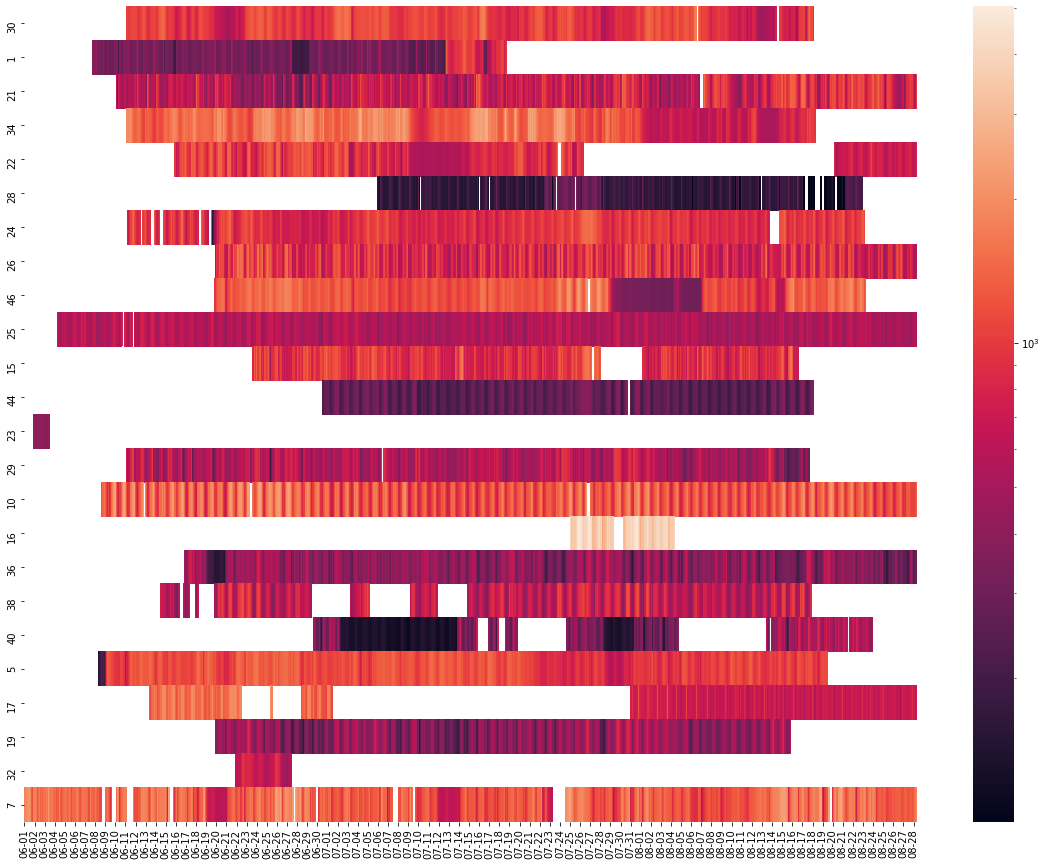

Working for CO
	Data collected
	Plotting


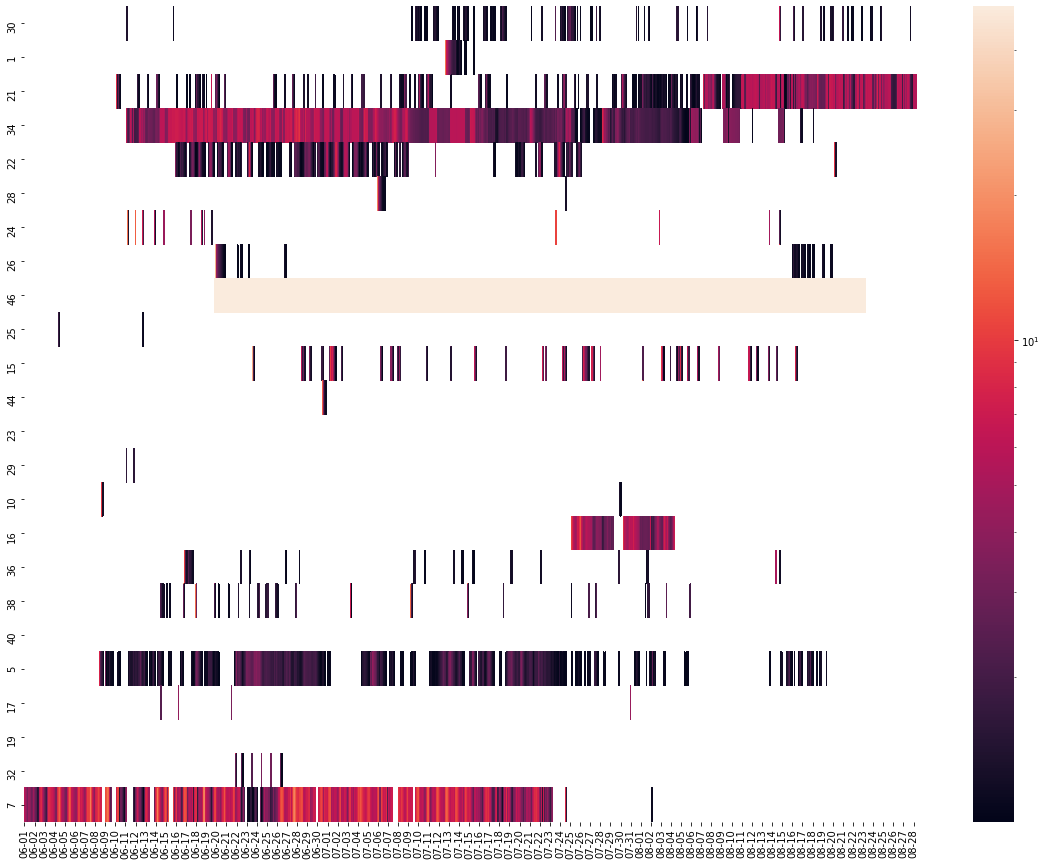

Working for NO2
	Data collected
	Plotting


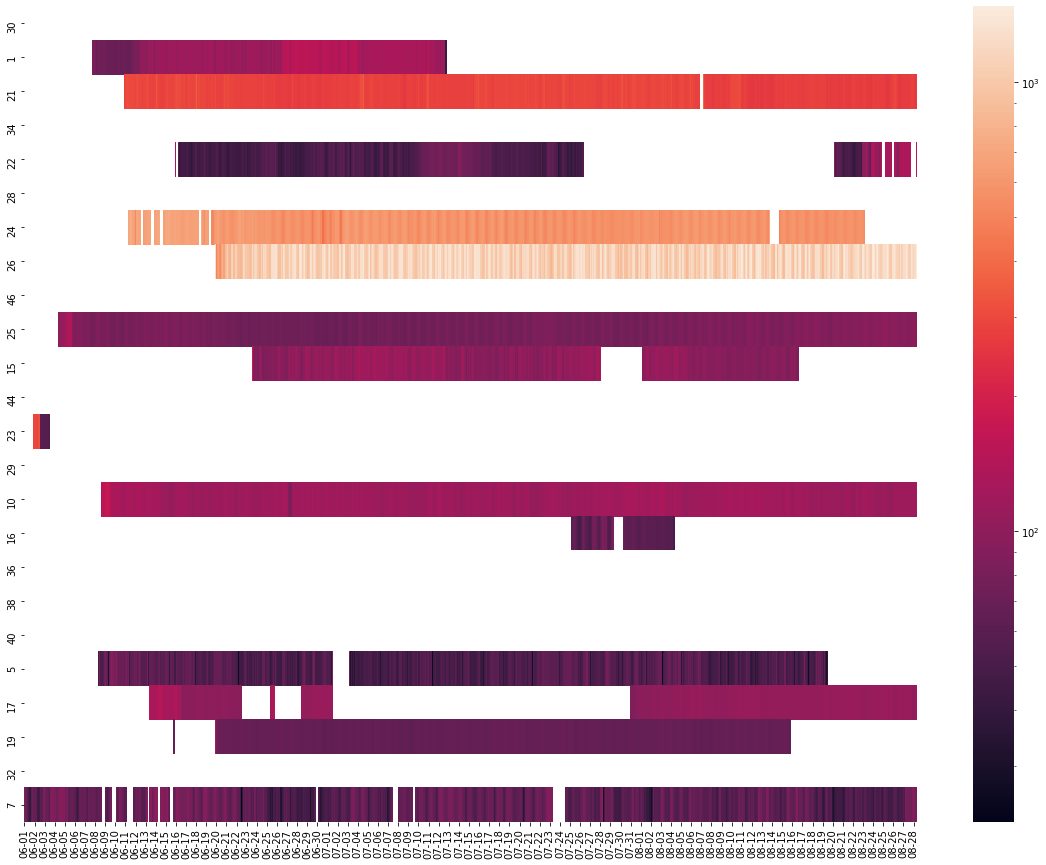

Working for T_NO2
	Data collected
	Plotting


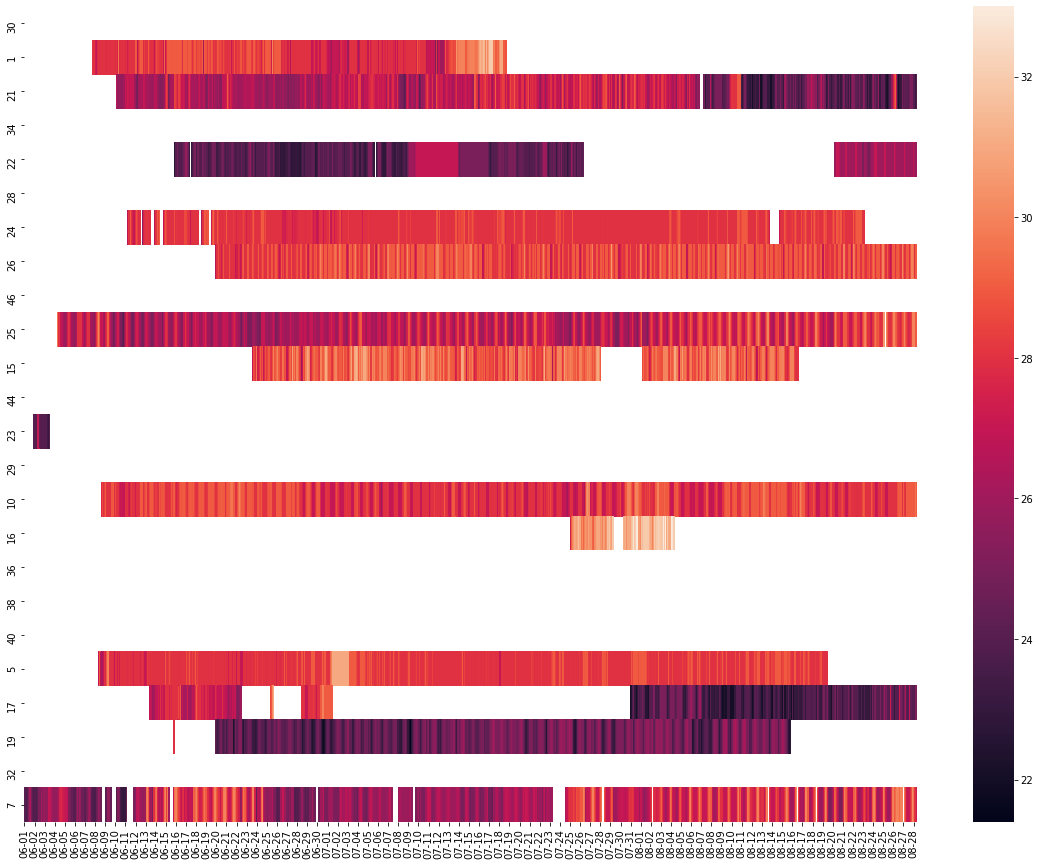

Working for Lux
	Data collected
	Plotting


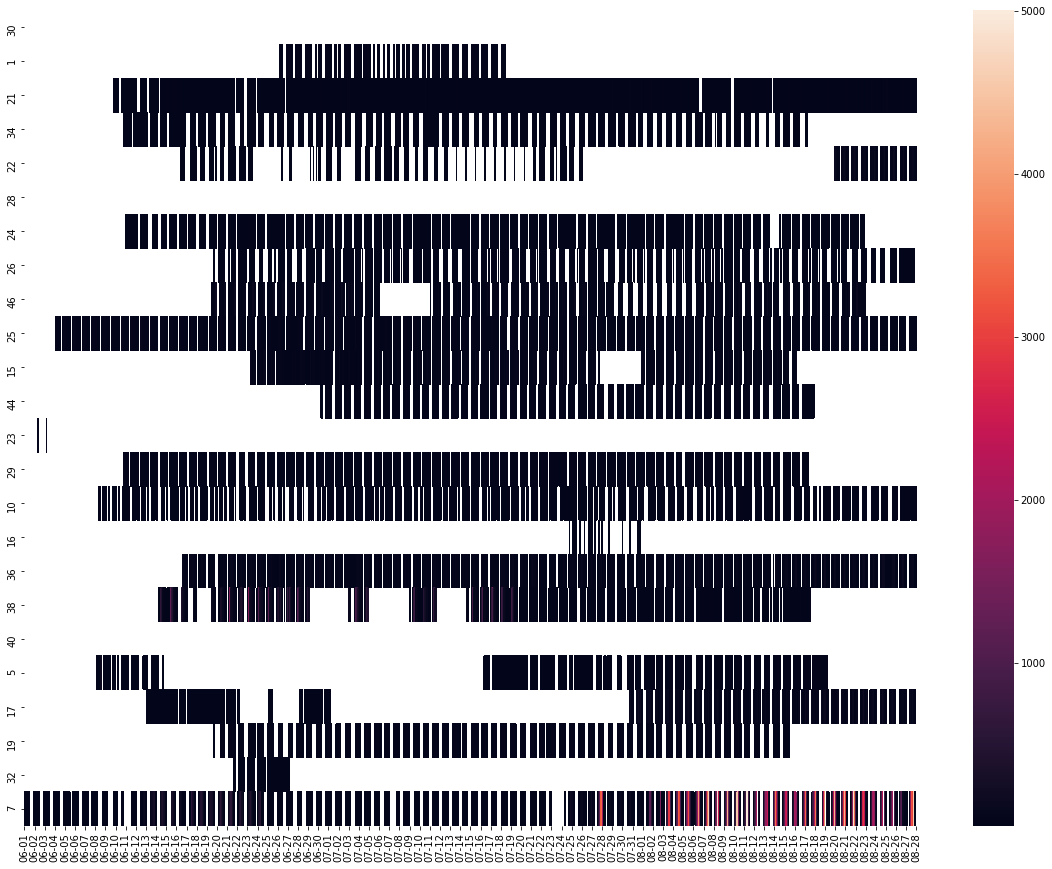

In [25]:
var_list = ['PM_C_2p5','CO2','CO','NO2','T_NO2','Lux']
limit_list = [[1,75],[1,2000],[1,20],[1,100],[1,50],[0,600000]]
for variable, limits in zip(var_list, limit_list):
    print(f'Working for {variable}')
    heatmap_df = pd.DataFrame()
    for beacon in beacon_data['Beacon'].unique():
        data_by_beacon = beacon_data[beacon_data['Beacon'] == beacon]
        data_by_beacon = data_by_beacon[data_by_beacon[variable] > 1]
        data_by_beacon = data_by_beacon.resample('1h').mean()
        sdate = datetime(2020,6,1)
        edate = datetime(2020,9,1)
        data_by_beacon = data_by_beacon[sdate:edate]
        heatmap_df = pd.concat([heatmap_df,data_by_beacon[variable]],axis=1)
        heatmap_df.rename(columns={variable:beacon}, inplace=True)

    print(f'\tData collected')
    fig, ax = plt.subplots(figsize=(20,15))
    df_to_plot = heatmap_df.T
    print(f'\tPlotting')
    if variable[0] in ['T','L']:
        sns.heatmap(df_to_plot,vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot))
    else:
        sns.heatmap(df_to_plot,norm=LogNorm(vmin=np.nanmin(df_to_plot),vmax=np.nanmax(df_to_plot)))
        
    x_labels = []
    for d in pd.date_range(sdate,edate-timedelta(days=1),freq='d'):
        x_labels.append(d.strftime('%m-%d'))
        
    ax.set_xticklabels(x_labels)
    
    plt.show()
    plt.close()

### Time Series Sensor Operation
Now we show individual beacons as a simplified time series to see that the sensors were operating.

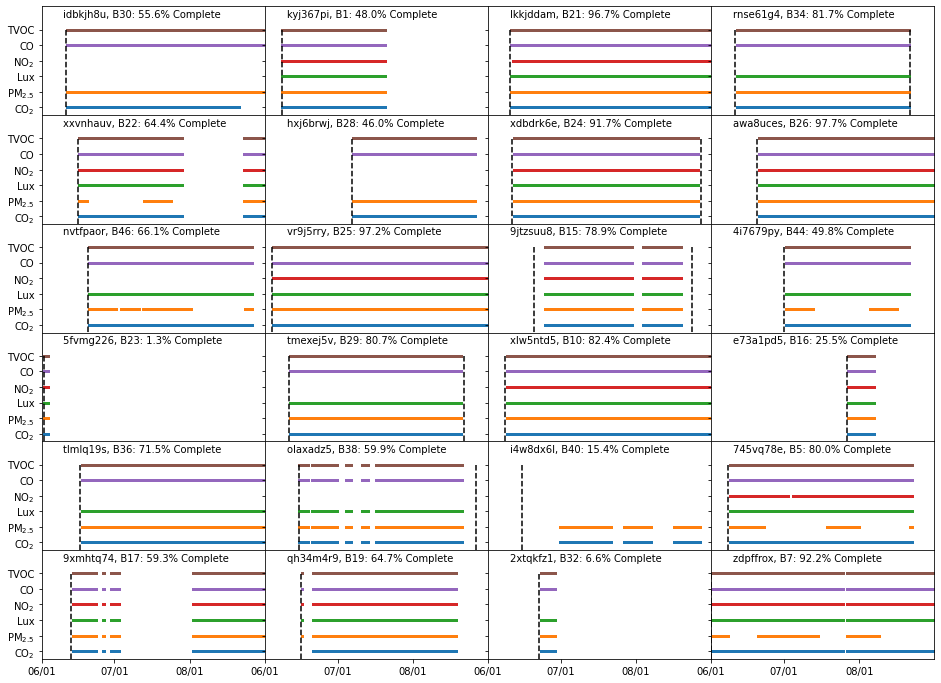

In [26]:
fig, axes = plt.subplots(6,4,figsize=(16,12),sharex=True,sharey='row')
rows = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5]
cols = [0,1,2,3]*6
sensors = ['CO2','PM_C_2p5','Lux','NO2','CO','TVOC']
sensor_datapoints_dict = {'CO2':0,'PM_C_2p5':0,'Lux':0,'NO2':0,'CO':0,'TVOC':0}
for beiwe, r, c in zip(beacon_data['Beiwe'].unique(),rows,cols):
    # restricting to participant
    beacon_by_beiwe = beacon_data[beacon_data['Beiwe'] == beiwe]
    beacon_by_beiwe = beacon_by_beiwe[details.loc[beiwe,'start_date']:details.loc[beiwe,'end_date']]
    beacon = beacon_by_beiwe['Beacon'][0]
    limits = [-50,0,-10,-1000,-1000,-50]
    # Getting overall percentage of data completion
    total_datapoints = (details.loc[beiwe,'return_date'] - details.loc[beiwe,'start_date'] + timedelta(days=1)).days
    # x24 x60 to get into minutes, /5 for interverals, x6 for number of sensors
    total_datapoints = total_datapoints * 24 * 60 / 5 * len(sensors)
    available_datapoints = 0
    for sensor in sensors:
        available_datapoints += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
        sensor_datapoints_dict[sensor] += np.count_nonzero(~np.isnan(beacon_by_beiwe[sensor]))
    total_percent = round(available_datapoints / total_datapoints * 100,1)
    
    i = 1
    ax = axes[r,c]
    for sensor, limit in zip(sensors,limits):
        beacon_by_beiwe[f'{sensor}_op'] = np.select([pd.to_numeric(beacon_by_beiwe[sensor],errors='coerce') > limit],[i])
        ax.scatter(beacon_by_beiwe.index,beacon_by_beiwe[f'{sensor}_op'],s=5,marker='s')
        i += 1
    # plotting start and stop dates
    ax.plot([details.loc[beiwe,'start_date'],details.loc[beiwe,'start_date']],[0,6],color='black',linestyle='dashed')
    ax.plot([details.loc[beiwe,'return_date']+timedelta(days=1),details.loc[beiwe,'return_date']+timedelta(days=1)],[0,6],color='black',linestyle='dashed')
    ax.text(datetime(2020,6,10),7,f'{beiwe}, B{beacon}: {total_percent}% Complete',va='center',ha='left')
    ax.set_ylim([0.5,7.5])
    ax.set_xlim([datetime(2020,6,1),datetime(2020,9,1)])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[6,7,8]))
    ax.set_yticks(np.arange(1,7,1))
    ax.set_yticklabels(['CO$_2$','PM$_{2.5}$','Lux','NO$_2$','CO','TVOC'])
    
plt.subplots_adjust(hspace=0,wspace=0)
plt.savefig('../reports/utx000_initial_update/figures/time-beacon-sensor-operation-comprehensive.pdf')
plt.show()
plt.close()

## How much data were collected?
Given the study period, we want to know how much of the possible data were collected

### Number of Hours
A nice metric would to be to see how many hours of data were collected. 

The number of hours is calculated as the sum of the hours each sensor on each beacon was operational.

In [43]:
# Getting number of datapoints
n_datapoints = 0
for sensor in ['TVOC','Lux','NO2','CO','CO2','PM_C_2p5']:
    data_per_sensor = beacon_data.loc[:,sensor]
    data_per_sensor.dropna(inplace=True)
    if sensor in ['NO2','CO']:
        t = len(beacon_data.loc[:,f'T_{sensor}'].dropna())
        rh = len(beacon_data.loc[:,f'RH_{sensor}'].dropna())
        print('Comparing DGS sensor readings:')
        print(f'\tT: {t}')
        print(f'\tRH: {rh}')
        print(f'\t{sensor}: {len(data_per_sensor)}')
        n_datapoints += max([t,rh,len(data_per_sensor)])
    else:
        print(f'{sensor}: {len(data_per_sensor)}')
        n_datapoints += len(data_per_sensor)
        
# datapoints are collected every five minutes, so we multiply the number of datapoints by 5 to get the minutes
n_hours = n_datapoints * 5 / 60
print(f'Number of hours of data collected: {n_hours}')
print(f'Number of days of data collected: {n_hours / 24}')

TVOC: 403256
Lux: 350686
Comparing DGS sensor readings:
	T: 248989
	RH: 249369
	NO2: 247719
Comparing DGS sensor readings:
	T: 407065
	RH: 407070
	CO: 407736
CO2: 406589
PM_C_2p5: 413925
Number of hours of data collected: 185963.41666666666
Number of days of data collected: 7748.475694444444


In [39]:
n_datapoints

2231561

In [28]:
total_sensor_datapoints = total_datapoints / len(sensors) * len(beacon_data['Beiwe'].unique())
total_no2_datapoints = total_datapoints / len(sensors) * 13
for key in sensor_datapoints_dict.keys():
    if key == 'NO2':
        percentage_complete = round(sensor_datapoints_dict[key] / total_no2_datapoints * 100,1)
    else:
        percentage_complete = round(sensor_datapoints_dict[key] / total_sensor_datapoints * 100,1)
    print(f'{key}: {percentage_complete}')

CO2: 63.3
PM_C_2p5: 64.4
Lux: 54.6
NO2: 71.1
CO: 63.4
TVOC: 62.7


## What are typical measurements?

### Histograms
These plots help show typical measurements by the sensors which we can use to refine our raw values

#### Raw Data
Here we summarize the distributions of values for the raw data. This helps us see what values we are measuring.

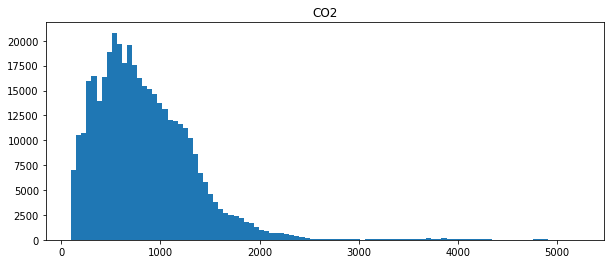

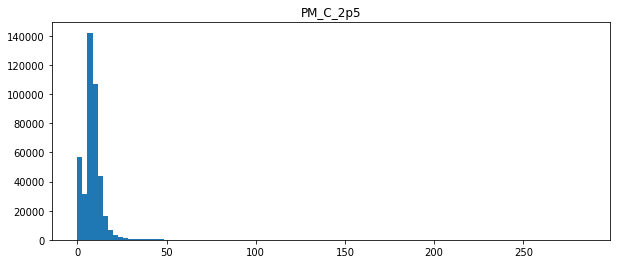

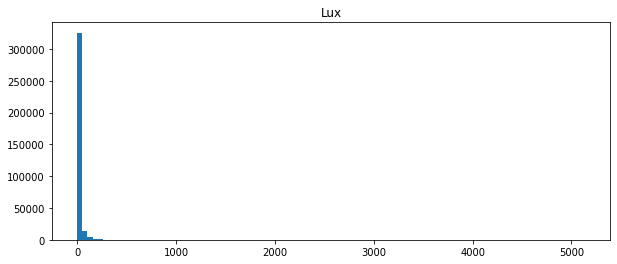

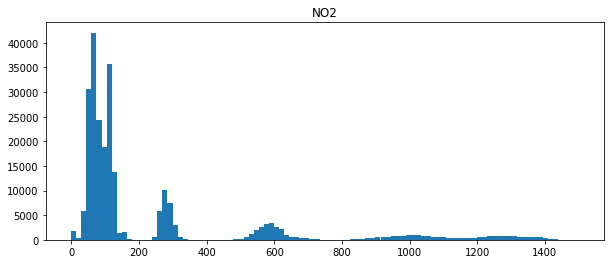

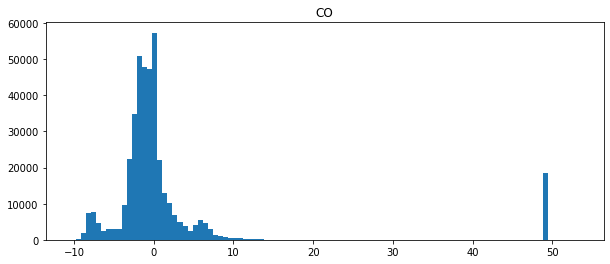

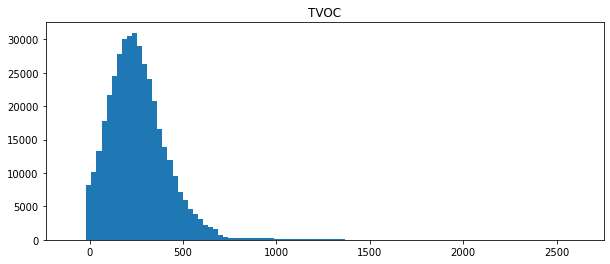

In [29]:
for pollutant in sensors:
    fig, ax = plt.subplots(figsize=(10,4))
    ax.hist(beacon_data[pollutant],bins=100)
    ax.set_title(pollutant)

Perhaps a certain participant has bad values, now we check the distributions of all the beacons still considering the raw values.

CO2


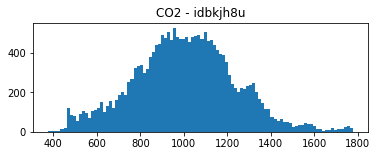

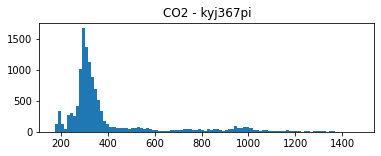

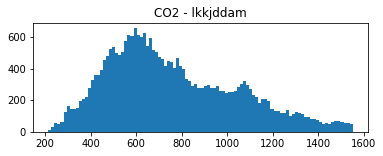

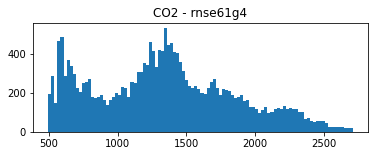

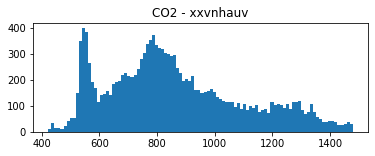

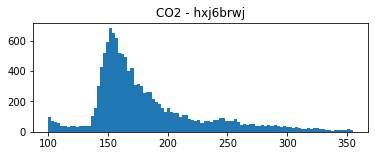

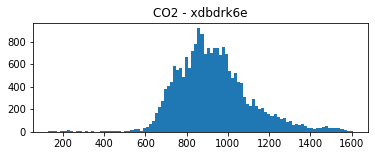

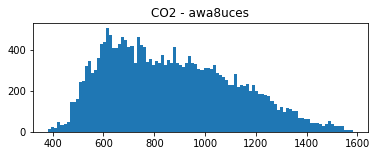

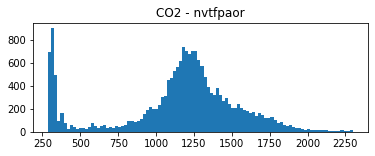

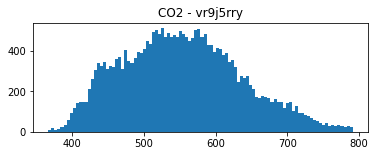

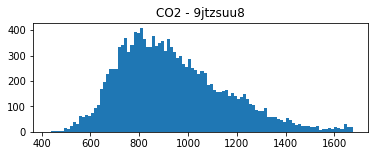

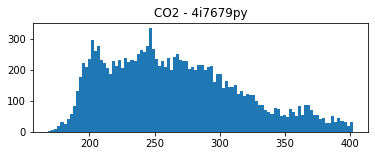

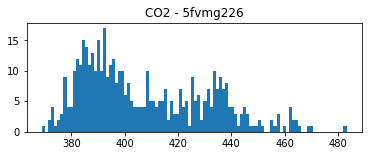

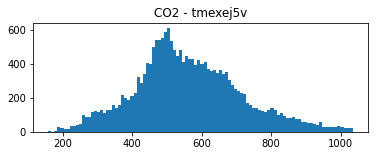

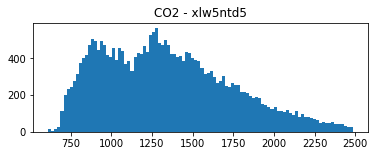

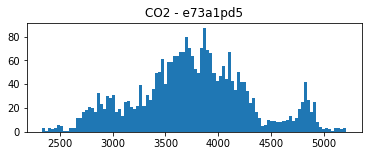

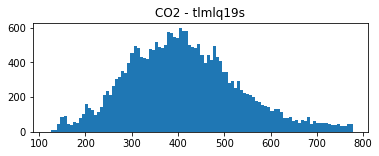

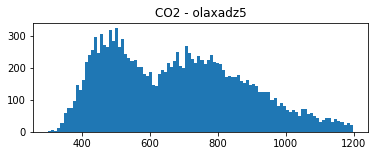

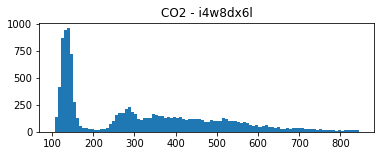

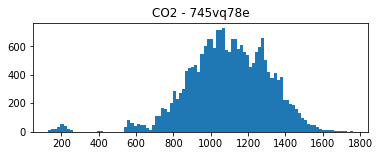

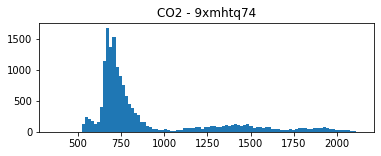

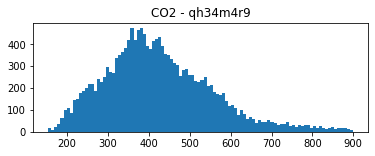

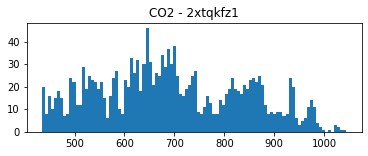

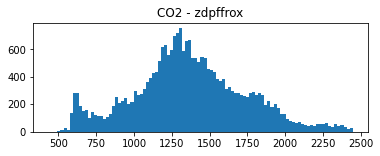

PM_C_2p5


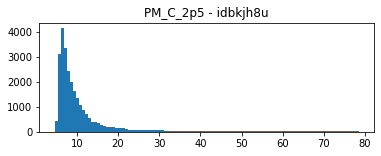

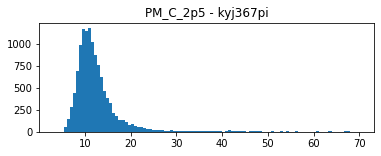

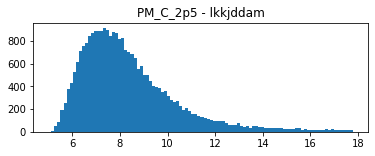

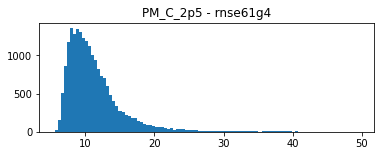

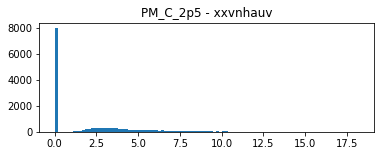

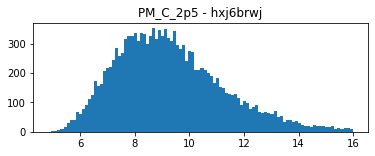

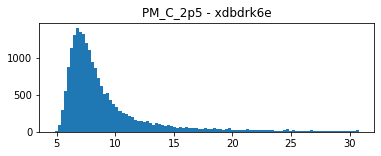

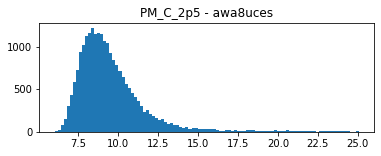

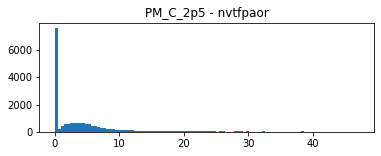

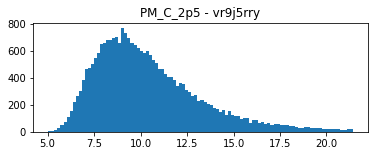

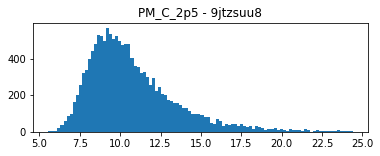

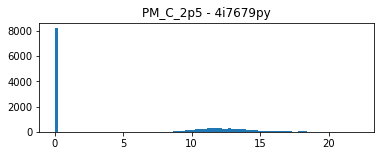

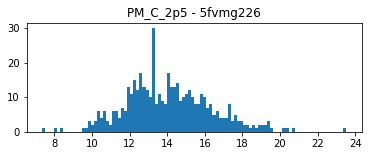

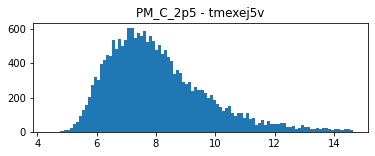

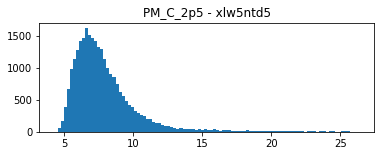

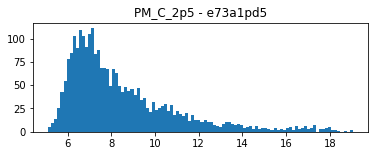

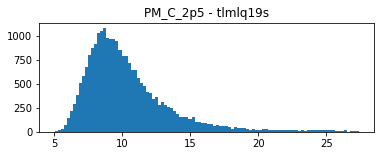

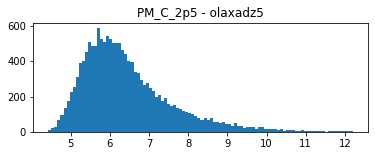

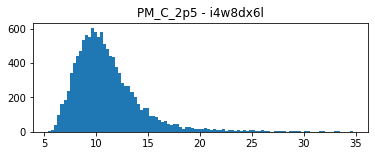

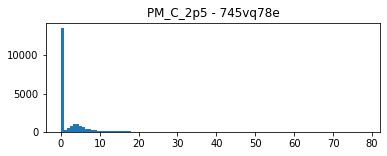

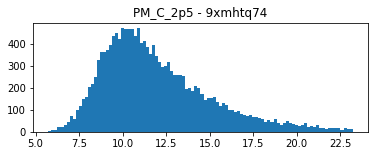

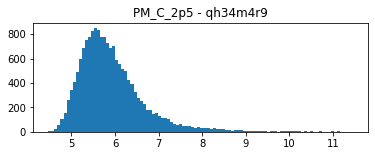

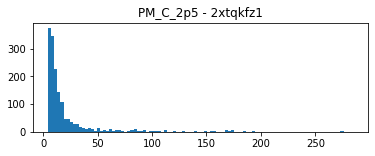

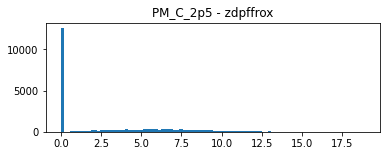

Lux


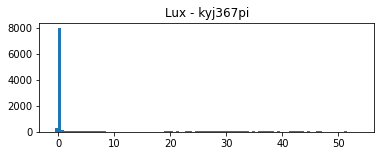

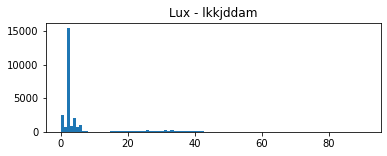

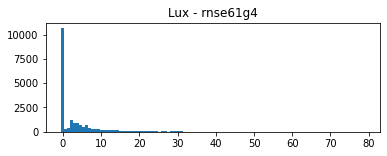

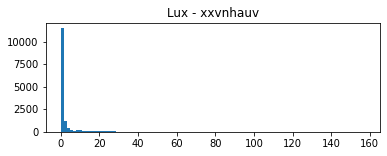

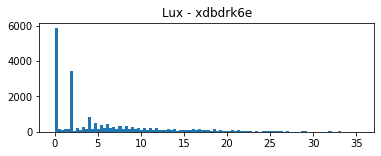

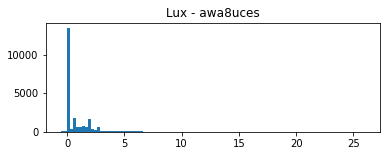

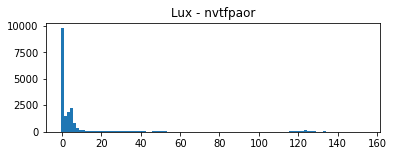

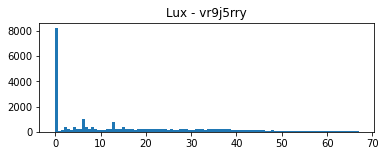

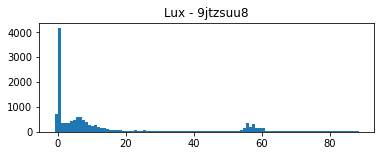

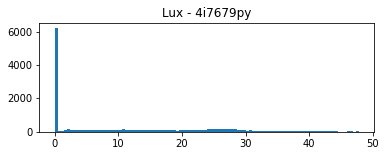

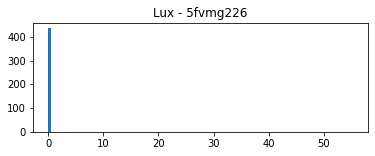

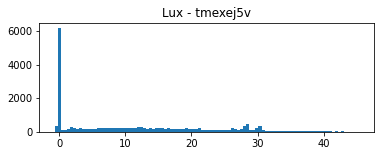

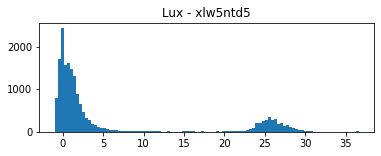

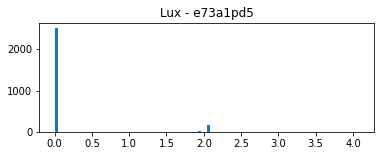

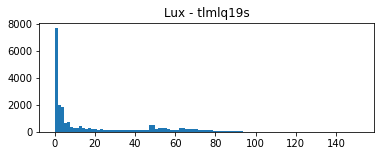

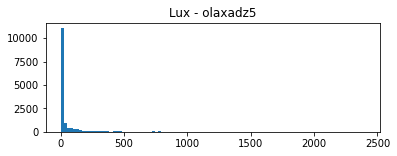

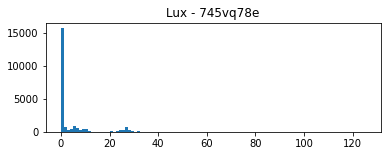

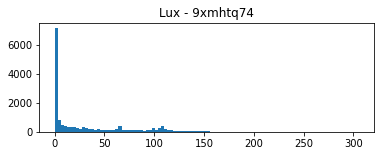

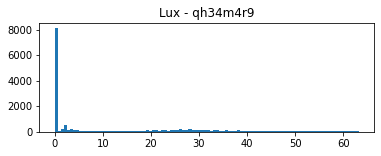

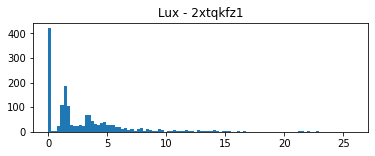

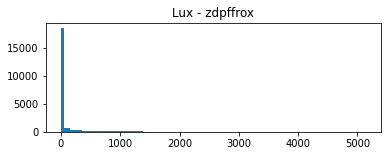

NO2


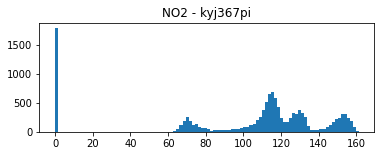

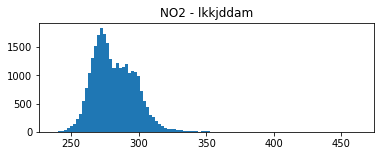

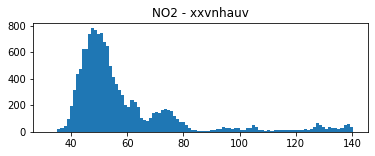

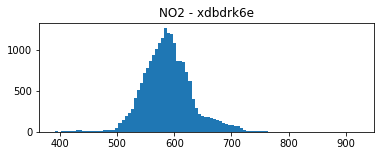

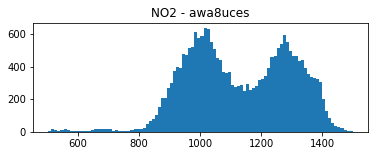

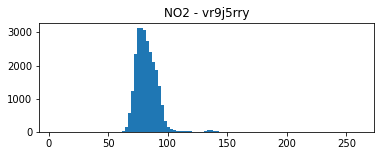

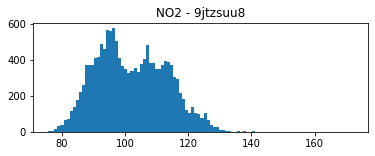

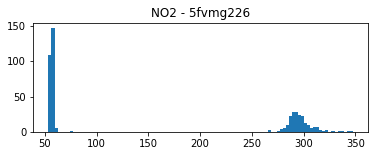

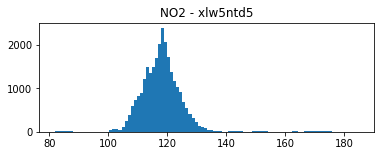

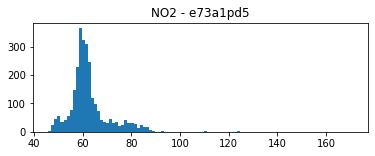

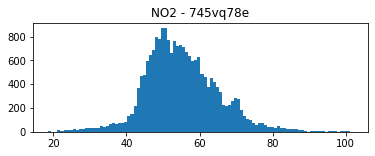

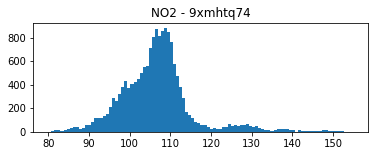

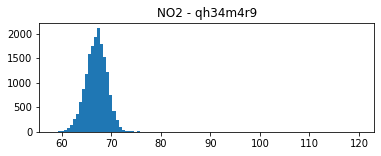

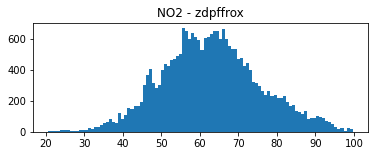

CO


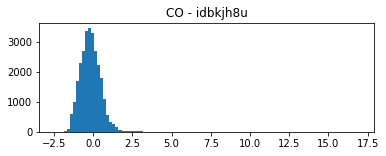

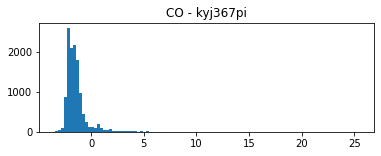

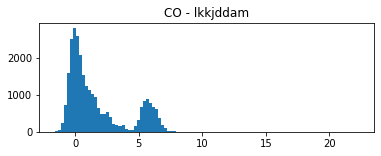

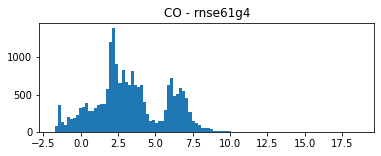

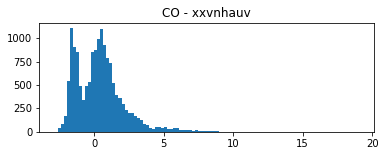

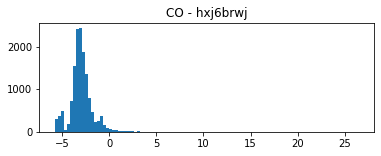

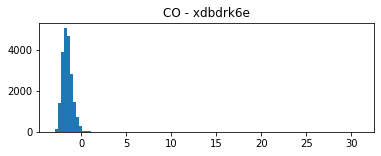

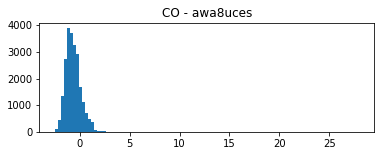

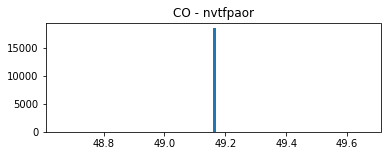

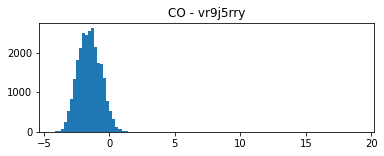

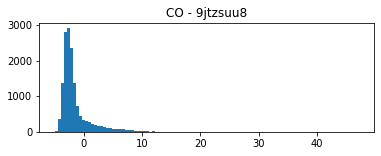

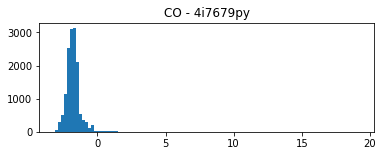

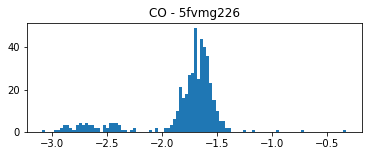

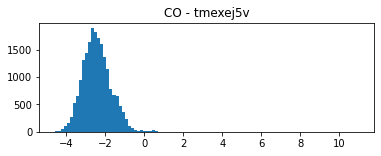

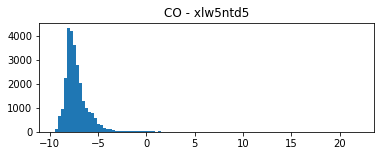

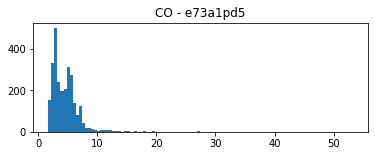

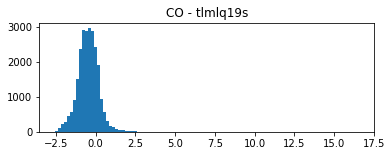

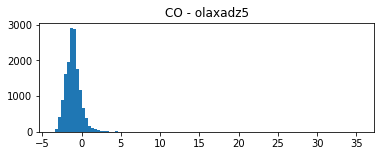

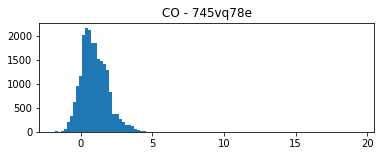

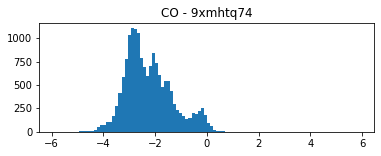

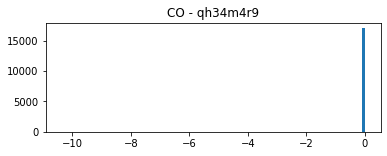

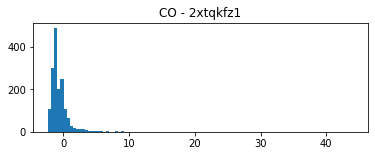

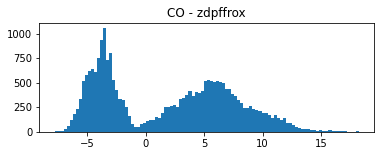

TVOC


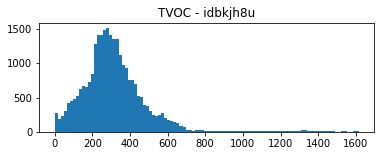

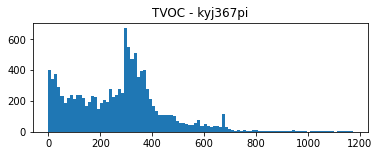

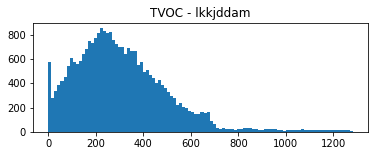

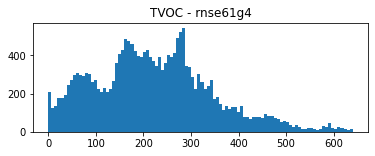

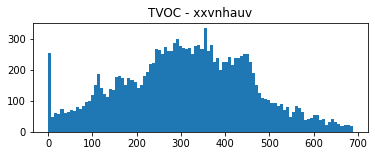

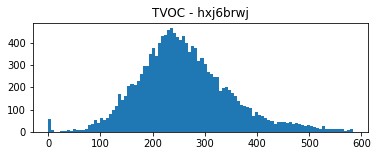

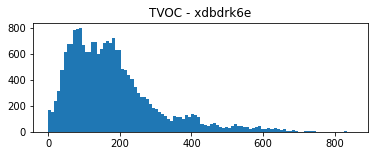

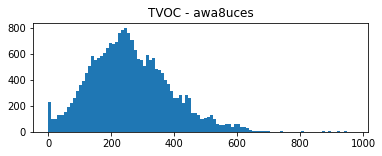

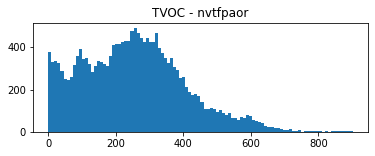

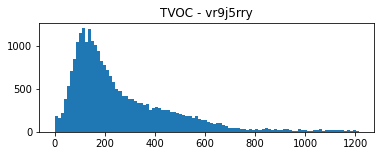

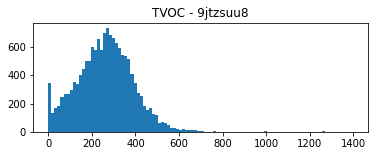

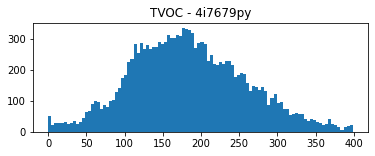

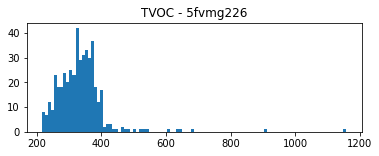

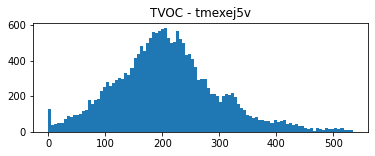

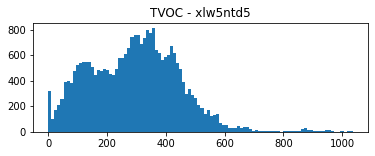

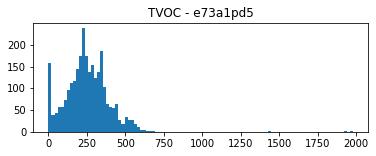

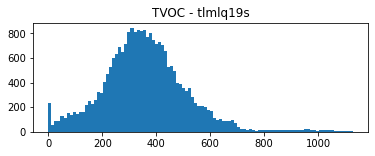

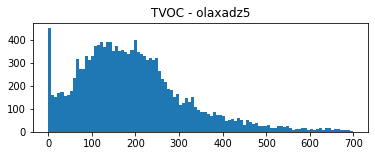

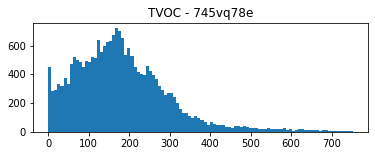

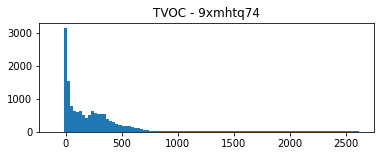

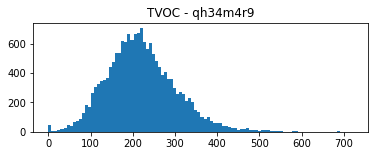

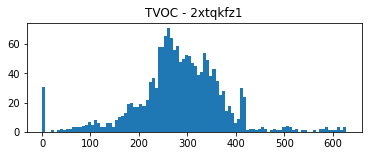

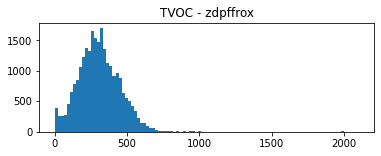

In [30]:
for pollutant in sensors:
    print(pollutant)
    for pt in beacon_data['Beiwe'].unique():
        beacon_pt = beacon_data[beacon_data['Beiwe'] == pt]
        if len(beacon_pt[pollutant].dropna()) > 0:
            fig, ax = plt.subplots(figsize=(6,2))
            ax.hist(beacon_pt[pollutant],bins=100)
            ax.set_title(f'{pollutant} - {pt}')

            plt.show()
            plt.close()

#### Notes
Some thoughts regarding the pre-processing

##### Carbon Dioxide
Shows that pre-processing cannot be done in bulk. Extreme values for one device might not be extreme for another device so each device should be processed separately before combining. 

##### Lux
We need to remove values that are -100 since those correspond to errors.


<div class="alert alert-block alert-success">
    Completed the above notes
</div>

# Analysis
Here we look at a few basic ideas 